<a href="https://colab.research.google.com/github/LEE-SANG-HYUK/Titanic/blob/main/titanic_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [45]:
import pandas as pd
import numpy as np
import re
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings('ignore')

# Going to use these 5 base models for the stacking
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC

In [46]:
train = pd.read_csv("/content/drive/MyDrive/train.csv")
test = pd.read_csv("/content/drive/MyDrive/test.csv")

In [47]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [48]:
PassengerId = test['PassengerId']

In [49]:
train['Ticket_type'] = train['Ticket'].apply(lambda x: x[0:3])

In [50]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Ticket_type
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,A/5
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,PC
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,STO
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,113
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,373


In [51]:
train['Ticket_type'] = train['Ticket_type'].astype('category')

In [52]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Ticket_type
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,A/5
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,PC
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,STO
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,113
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,373


In [53]:
train['Ticket_type']

0      A/5
1      PC 
2      STO
3      113
4      373
      ... 
886    211
887    112
888    W./
889    111
890    370
Name: Ticket_type, Length: 891, dtype: category
Categories (154, object): ['110', '111', '112', '113', ..., 'W./', 'W.E', 'W/C', 'WE/']

In [54]:
train['Ticket_type'] = train['Ticket_type'].cat.codes

In [55]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Ticket_type
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,124
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,137
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,148
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,3
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,97


In [56]:
train['Ticket_type'].value_counts()

137    60
83     53
81     48
3      47
130    28
       ..
114     1
118     1
68      1
31      1
32      1
Name: Ticket_type, Length: 154, dtype: int64

In [57]:
test['Ticket_type'] = test['Ticket'].apply(lambda x: x[0:3])
test['Ticket_type'] = test['Ticket_type'].astype('category')
test['Ticket_type'] = test['Ticket_type'].cat.codes

In [58]:
full_data = [train, test]

In [59]:
full_data

[     PassengerId  Survived  Pclass  ... Cabin Embarked  Ticket_type
 0              1         0       3  ...   NaN        S          124
 1              2         1       1  ...   C85        C          137
 2              3         1       3  ...   NaN        S          148
 3              4         1       1  ...  C123        S            3
 4              5         0       3  ...   NaN        S           97
 ..           ...       ...     ...  ...   ...      ...          ...
 886          887         0       2  ...   NaN        S           23
 887          888         1       1  ...   B42        S            2
 888          889         0       3  ...   NaN        S          150
 889          890         1       1  ...  C148        C            1
 890          891         0       3  ...   NaN        Q           94
 
 [891 rows x 13 columns],      PassengerId  Pclass  ... Embarked Ticket_type
 0            892       3  ...        Q          58
 1            893       3  ...        S  

In [60]:
# Some extra features, not necessarily important
# Gives the length of the name
# train['Name_length'] = train['Name'].apply(len)
# test['Name_length'] = test['Name'].apply(len)
train['Words_Count'] = train['Name'].apply(lambda x: len(x.split()))
test['Words_Count'] = test['Name'].apply(lambda x: len(x.split()))

In [61]:
train['Words_Count']

0      4
1      7
2      3
3      7
4      4
      ..
886    3
887    4
888    5
889    4
890    3
Name: Words_Count, Length: 891, dtype: int64

In [62]:
# Feature that tells whether a passenger had a cabin on the Titanic
train['Has_Cabin'] = train["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
test['Has_Cabin'] = test["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

In [63]:
train['Has_Cabin']

0      0
1      1
2      0
3      1
4      0
      ..
886    0
887    1
888    0
889    1
890    0
Name: Has_Cabin, Length: 891, dtype: int64

In [64]:
type(train['Cabin'][0])

float

In [65]:
# Feature engineering steps taken from Sina
# Create new feature FamilySize as a combination of SibSp and Parch
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

In [66]:
# Create new feature IsAlone from FamilySize
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

In [67]:
# Remove all NULLS in the Embarked column
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')

In [68]:
# Remove all NULLS in the Fare column and create a new feature CategoricalFare
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())
train['CategoricalFare'] = pd.qcut(train['Fare'], 4)

In [69]:
# Create a New feature CategoricalAge
for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)
train['CategoricalAge'] = pd.cut(train['Age'], 5)

In [70]:
# Define function to extract titles from passenger names
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

In [71]:
ti = re.search(' ([A-Za-z]+)\.', train.loc[3, 'Name'])

In [72]:
ti.group(1)

'Mrs'

In [73]:
train.loc[0:5, 'Name']

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
5                                     Moran, Mr. James
Name: Name, dtype: object

In [74]:
# Create a new feature Title, containing the titles of passenger names
for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)

In [75]:
# Group all non-common titles into one single grouping "Rare"
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

In [76]:
for i, dataset in enumerate(full_data):
    print(dataset['Title'].value_counts())
    print(i)

Mr        517
Miss      185
Mrs       126
Master     40
Rare       23
Name: Title, dtype: int64
0
Mr        240
Miss       79
Mrs        72
Master     21
Rare        6
Name: Title, dtype: int64
1


In [77]:
for dataset in full_data:
     # Mapping Sex
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
    
     # Mapping titles
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)
    
     # Mapping Embarked
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    
    # Mapping Fare
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] 						                  = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] 							                    = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    # Mapping Age
    dataset.loc[ dataset['Age'] <= 16, 'Age'] 					               = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age']                           = 4 ;

In [78]:
full_data[0]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Ticket_type,Words_Count,Has_Cabin,FamilySize,IsAlone,CategoricalFare,CategoricalAge,Title
0,1,0,3,"Braund, Mr. Owen Harris",1,1,1,0,A/5 21171,0,NaN,0,124,4,0,2,0,"(-0.001, 7.91]","(16.0, 32.0]",1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,0,PC 17599,3,C85,1,137,7,1,2,0,"(31.0, 512.329]","(32.0, 48.0]",3
2,3,1,3,"Heikkinen, Miss. Laina",0,1,0,0,STON/O2. 3101282,1,NaN,0,148,3,0,1,1,"(7.91, 14.454]","(16.0, 32.0]",2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,2,1,0,113803,3,C123,0,3,7,1,2,0,"(31.0, 512.329]","(32.0, 48.0]",3
4,5,0,3,"Allen, Mr. William Henry",1,2,0,0,373450,1,NaN,0,97,4,0,1,1,"(7.91, 14.454]","(32.0, 48.0]",1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",1,1,0,0,211536,1,NaN,0,23,3,0,1,1,"(7.91, 14.454]","(16.0, 32.0]",5
887,888,1,1,"Graham, Miss. Margaret Edith",0,1,0,0,112053,2,B42,0,2,4,1,1,1,"(14.454, 31.0]","(16.0, 32.0]",2
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",0,0,1,2,W./C. 6607,2,NaN,0,150,5,0,4,0,"(14.454, 31.0]","(-0.08, 16.0]",2
889,890,1,1,"Behr, Mr. Karl Howell",1,1,0,0,111369,2,C148,1,1,4,1,1,1,"(14.454, 31.0]","(16.0, 32.0]",1


In [89]:
train.head()

,Pclass,Sex,Age,Parch,Fare,Embarked,Ticket_type,Words_Count,Has_Cabin,FamilySize,IsAlone,Title
0,3,1,1,0,0,0,124,4,0,2,0,1
1,1,0,2,0,3,1,137,7,1,2,0,3
2,3,0,1,0,1,0,148,3,0,1,1,2
3,1,0,2,0,3,0,3,7,1,2,0,3
4,3,1,2,0,1,0,97,4,0,1,1,1


In [79]:
# Feature selection
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis = 1)
train = train.drop(['CategoricalAge', 'CategoricalFare'], axis = 1)
test  = test.drop(drop_elements, axis = 1)

In [80]:
train.shape

(891, 13)

In [81]:
test.shape

(418, 12)

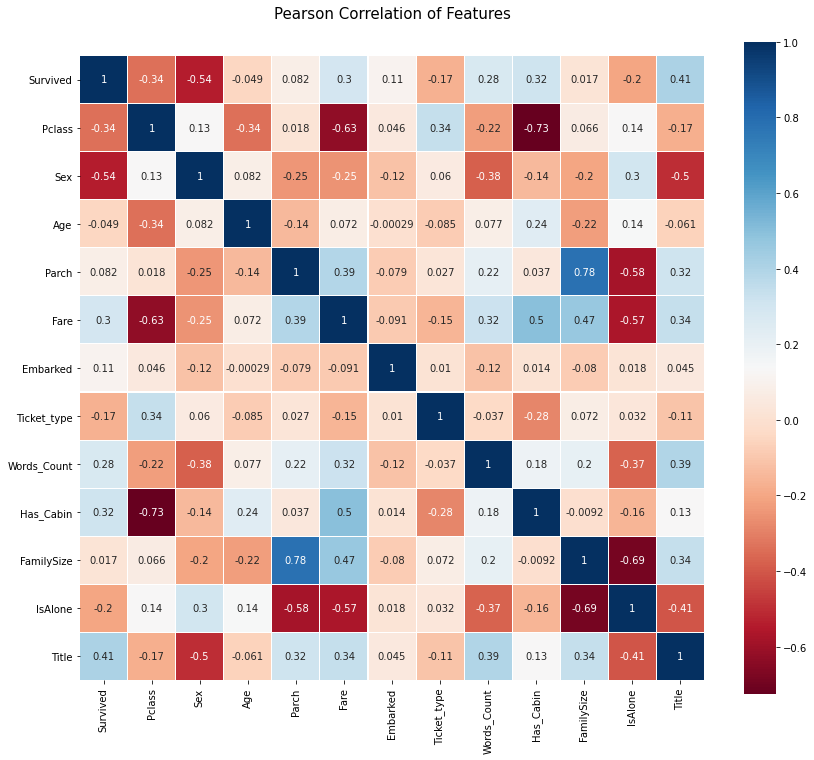

In [82]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

In [83]:
y_train = train['Survived'].ravel()
train = train.drop(['Survived'], axis=1)
x_train = train.values # Creates an array of the train data
x_test = test.values 

In [91]:
from sklearn.model_selection import train_test_split

In [92]:
xtrain, xtest, ytrain, ytest = train_test_split(x_train, y_train, test_size=0.25, random_state=1)

In [97]:
gbm = xgb.XGBClassifier(
    #learning_rate = 0.02,
 n_estimators= 2000,
 max_depth= 4,
 min_child_weight= 2,
 #gamma=1,
 gamma=0.9,                        
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread= -1,
 scale_pos_weight=1).fit(xtrain, ytrain)
#xgb_predictions = gbm.predict(x_test)

In [87]:
gbm.score(x_train,y_train)

0.9405162738496072

In [98]:
gbm.score(xtrain,ytrain)

0.937125748502994

In [99]:
gbm.score(xtest,ytest)

0.7892376681614349

In [85]:
StackingSubmission = pd.DataFrame({ 'PassengerId': PassengerId,
                            'Survived': xgb_predictions })

In [86]:
StackingSubmission

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [88]:
# Generate Submission File 
StackingSubmission.to_csv("XGB.csv", index=False)
StackingSubmission

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
